In [1]:
import sys
import os

SCRIPT_PATH = os.path.join(os.path.abspath(os.path.dirname('../__file__')), 'script')
sys.path.insert(0, SCRIPT_PATH)

from markov_device import *
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

ACT-R connection has been started.


# Compare MB vs. MF


In this analysis notebook, we're gonna compare the performance of two models from x following aspects

- P(stay)
- rewards gained
- utility trace

## Stay Probability

RL Hypothesis:
![RL P(Stay)](https://www.ncbi.nlm.nih.gov/pmc/articles/instance/3077926/bin/nihms280176f2.jpg)

In [2]:
m1 = MarkovACTR(setup=False) 
m1.setup(model="markov-model1", verbose=False, 
        task_params={'REWARD_PROBABILITY':.9, 'REWARD':{'B1': 2, 'B2': 0, 'C1': 0, 'C2': 2}},
        actr_params={'ans':.5, 'mas':.5, 'egs':.5})
print(m1)
m1.run_experiment(500)

######### SETUP MODEL markov-model1 #########
 	>> TASK PARAMETERS: {'MARKOV_PROBABILITY': 0.7, 'REWARD_PROBABILITY': 0.9, 'REWARD': {'B1': 2, 'B2': 0, 'C1': 0, 'C2': 2}} <<
 	>> ACT-R PARAMETERS: {'v': None, 'seed': [100, 0], 'ans': 0.5, 'le': 1.0, 'mas': 0.5, 'egs': 0.5, 'alpha': 0.2, 'imaginal-activation': 1.0} <<



In [3]:
m2 = MarkovACTR(setup=False) 
m2.setup(model="markov-model2", verbose=False, 
        task_params={'REWARD_PROBABILITY':.9, 'REWARD':{'B1': 2, 'B2': 0, 'C1': 0, 'C2': 2}},
        actr_params={'ans':.5, 'mas':.5, 'egs':.5})
print(m2)
m2.run_experiment(500)

######### SETUP MODEL markov-model2 #########
 	>> TASK PARAMETERS: {'MARKOV_PROBABILITY': 0.7, 'REWARD_PROBABILITY': 0.9, 'REWARD': {'B1': 2, 'B2': 0, 'C1': 0, 'C2': 2}} <<
 	>> ACT-R PARAMETERS: {'v': None, 'seed': [100, 0], 'ans': 0.5, 'le': 1.0, 'mas': 0.5, 'egs': 0.5, 'alpha': 0.2, 'imaginal-activation': 1.0} <<



In [4]:
df1, df2 = m1.calculate_stay_probability(), m2.calculate_stay_probability()
df1_state1stay = df1.groupby(['received_reward', 'reward_frequency', 'state_frequency']).agg({'state1_stay': lambda x: x.mean(skipna=True)}).reset_index()
df2_state1stay = df2.groupby(['received_reward', 'reward_frequency', 'state_frequency']).agg({'state1_stay': lambda x: x.mean(skipna=True)}).reset_index()

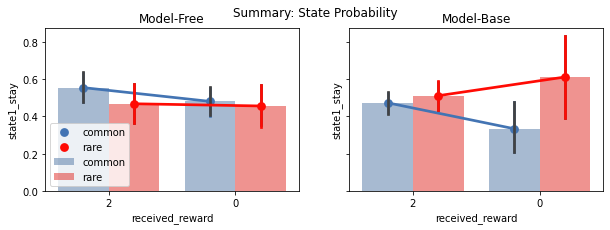

In [42]:
# Create an array with the colors you want to use
my_palette = sns.color_palette(["#4374B3", "#FF0B04"])

fig, axes = plt.subplots(1, 2, figsize=(10,3), sharex=True, sharey=True)
fig.suptitle('Summary: State Probability')
sns.barplot(data=df1, x='received_reward', y='state1_stay', 
            hue='state_frequency', palette=my_palette, alpha=.5,
            order = sorted(df1['received_reward'].unique(), reverse=True), 
            hue_order=['common', 'rare'],
            ax=axes[0]) 
sns.pointplot(data=df1, x='received_reward', y='state1_stay', dodge=0.4,
            hue='state_frequency', palette=my_palette,
            order = sorted(df1['received_reward'].unique(), reverse=True), 
            hue_order=['common', 'rare'],
            ax=axes[0]) 

sns.barplot(data=df2, x='received_reward', y='state1_stay',
            hue='state_frequency', palette=my_palette, alpha=.5,
            order = sorted(df2['received_reward'].unique(), reverse=True), 
            hue_order=['common', 'rare'],
            ax=axes[1]) 
sns.pointplot(data=df2, x='received_reward', y='state1_stay',  dodge=0.4,
            hue='state_frequency', palette=my_palette,
            order = sorted(df2['received_reward'].unique(), reverse=True), 
            hue_order=['common', 'rare'],
            ax=axes[1]) 

axes[0].legend(loc=0)
axes[1].legend_.remove()
axes[0].set_title('Model-Free')
axes[1].set_title('Model-Base')

plt.show()

## Utility and Activation Trace

In [44]:
def df_trace(m, title_name='model-free'): 
    df = m.calculate_stay_probability()
    print(">> %s << \n\tgained rewards: %.2f" % (title_name, df['received_reward'].sum()/len(df)))
    
    # production trace
    df1 = m.df_actr_production_traces(parameter_name=':utility')
    df1['index_bin'] = pd.cut(df1['index'], 10, labels=False, ordered=False, right=False)

    # memory trace
    try: 
        df2 = m.df_actr_chunk_traces(parameter_name=':Last-Retrieval-Activation')
        df2['index_bin'] = pd.cut(df2['index'], 10, labels=False)  
        df2.replace(to_replace=[None], value=np.nan, inplace=True)
        #selected_memory = df2.groupby('memory')[':Last-Retrieval-Activation'].mean().sort_values(ascending = False).index[:4].values
        selected_memory = ['M1-1', 'M1-2', 'M1-3', 'M1-4']
        df2 = df2[df2.apply(lambda x: x['memory'] in selected_memory, axis=1)]
    except:
        print('no memory trace')
        df2 = None
    finally:
        df1 = df1.astype({'index_bin':'float', ':utility':'float'})  
        df2 = df2.astype({'index_bin':'float', ':Last-Retrieval-Activation':'float'})  
        return df1, df2 

>> model-free << 
	gained rewards: 0.97
>> model-base << 
	gained rewards: 1.74


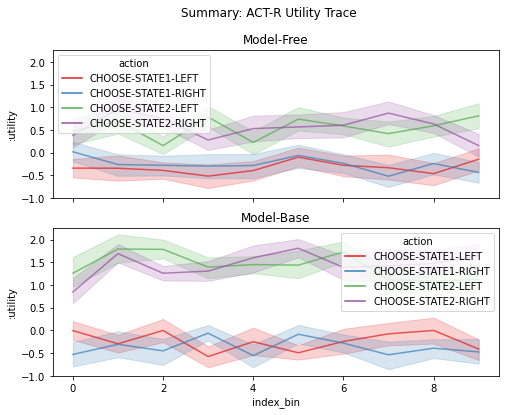

In [45]:
df1_utrace, df1_atrace = df_trace(m1, 'model-free')
df2_utrace, df2_atrace = df_trace(m2, 'model-base')

fig, axes = plt.subplots(2, 1, figsize=(8,6), sharex=True, sharey=True)
fig.suptitle('Summary: ACT-R Utility Trace')
sns.lineplot(data = df1_utrace, x='index_bin', y=':utility', hue='action', alpha=.7, palette='Set1', ax=axes[0])
sns.lineplot(data = df2_utrace, x='index_bin', y=':utility', hue='action', alpha=.7, palette='Set1', ax=axes[1])
axes[0].set_title('Model-Free')
axes[1].set_title('Model-Base')

plt.show()

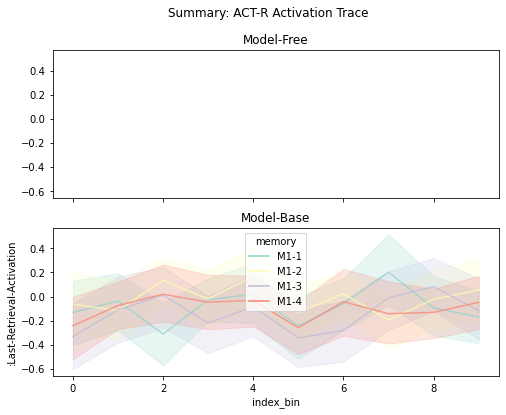

In [48]:
fig, axes = plt.subplots(2, 1, figsize=(8,6), sharex=True, sharey=True)
fig.suptitle('Summary: ACT-R Activation Trace')
#sns.lineplot(data = df1_atrace, x='index_bin', y=':Last-Retrieval-Activation', hue='memory', alpha=.7, palette='Set3', ax=axes[0])
sns.lineplot(data = df2_atrace, x='index_bin', y=':Last-Retrieval-Activation', hue='memory', alpha=.7, palette='Set3', ax=axes[1])
axes[0].set_title('Model-Free')
axes[1].set_title('Model-Base')
plt.show()